In [1]:
# See https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/superdense-coding.ipynb
from qiskit.quantum_info import Statevector
from dbcquantum.circuit import AssertQuantumCircuit, AQCMeasure
from dbcquantum.utils import eq_state
from qiskit.opflow import Zero, One
from math import sqrt

In [2]:
# Choose one of the following:
# message: str = "00"
message: str = "01"
# message: str = "10"
# message: str = "11"

In [3]:
bell_circ = AssertQuantumCircuit(2)
bell_circ.h(1)
bell_circ.cx(1,0)

bell_circ.add_pre_condition(
    "bell_input_|00>",
    lambda pre_state: eq_state(pre_state, Zero ^ Zero),  # type: ignore
)

bell_circ.add_post_condition(
    "bell_output_bell",
    lambda post_state: eq_state(post_state, 1 / sqrt(2) * ((Zero ^ Zero) + (One ^ One))),  # type: ignore
)

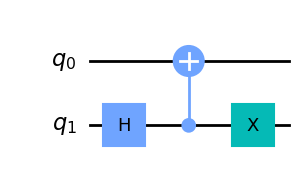

In [4]:
encoded = AssertQuantumCircuit(2)
encoded.append(bell_circ, [0,1])
# encoded.barrier()

if message == "00":
    expected_encoded_state = 1 / sqrt(2) * ((Zero ^ Zero) + (One ^ One))  # type: ignore
elif message == "01":
    encoded.x(1)
    expected_encoded_state = 1 / sqrt(2) * ((Zero ^ One) + (One ^ Zero))  # type: ignore
elif message == "10":
    encoded.z(1)
    expected_encoded_state = 1 / sqrt(2) * ((Zero ^ Zero) - (One ^ One))  # type: ignore
elif message == "11":
    encoded.z(1)
    encoded.x(1)
    expected_encoded_state = 1 / sqrt(2) * ((Zero ^ One) - (One ^ Zero))  # type: ignore

encoded.add_post_condition("encoded_state", lambda post_state: eq_state(post_state, expected_encoded_state))

encoded.remove_assertions().draw("mpl")

In [5]:
decoded: AssertQuantumCircuit[str] = AssertQuantumCircuit(2)
decoded.append(encoded, [0,1])
# decoded.barrier()
decoded.cx(1,0)
decoded.h(1)

def decoded_cond(post_state: Statevector, param: str)-> bool:
    if param == "00":
        return eq_state(post_state, Zero ^ Zero) # type: ignore
    elif param == "01":
        return eq_state(post_state, Zero ^ One) # type: ignore
    elif param == "10":
        return eq_state(post_state, One ^ Zero) # type: ignore
    else:
        return eq_state(post_state, One ^ One) # type: ignore

decoded.add_post_condition_use_param("decoded_cond", decoded_cond)

{'01': 1000}


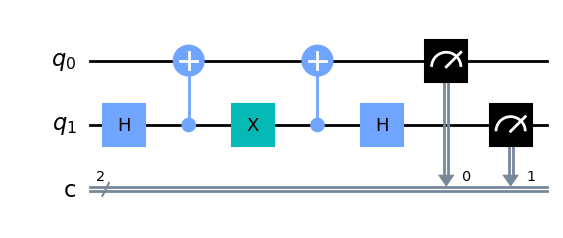

In [6]:
measure = AQCMeasure(decoded, lambda result: result.get_counts())
# All measurement results are equal to message.
measure.add_condition_use_param("measure_condition", lambda pre_measure_state, result, count, param: count[param] == sum(count.values())) # type: ignore
print(measure.run(shots=1000, param=message))
measure.remove_assertions_to_circuit().draw("mpl")

In [7]:
%%timeit -n 1 -r 5
measure.run(shots=1000, param=message)

38.4 ms ± 4.61 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [8]:
print("#qubits=")
print(measure.num_qubits)
print()
print("#gates=")
print(sum(measure.remove_assertions_to_circuit().count_ops().values()))

#qubits=
2

#gates=
7
